# Reapply existing signatures

Simple example of fitting the provided example data to the 5 ES model

In [1]:
from enterosig import reapply, models
from enterosig.reapply import to_relative
import numpy as np

result = reapply(
    abundance=models.example_abundance(), 
    model_w=models.five_es()
)

result.model_fit.describe()

,model_fit
count,1152.000000
mean,0.636285
std,0.304325
min,0.010710
25%,0.354922
50%,0.733839
75%,0.914359
max,0.993902


The results object is a named tuple. The Enterosignature weights for each sample are in the H matrix of the results object.

In [2]:
result.h.head()

,ES_Bact,ES_Bifi,ES_Esch,ES_Prev,ES_Firm
W2.35.ST,1.077887e-03,1.366361e-08,0.000628,0.017005,1.196575e-02
W1.41.ST,8.275341e-05,5.155330e-04,0.000027,0.035901,4.199402e-03
W2.42.ST,1.196438e-05,1.945581e-03,0.013511,0.029275,1.750382e-15
W1.39.ST,6.609590e-15,6.081661e-03,0.001049,0.027632,4.643657e-03
M1.61.ST,4.949388e-07,6.993441e-05,0.003599,0.031431,4.386457e-03


For most analyses, you will likely want to convert these to relative abundances as below. Note that when transformed to relative values,  $W \times H \not\approx X$.

In [3]:
rel_results = to_relative(result)
# We can assert that all the rows now sum to 1
assert all(np.isclose(rel_results.h.sum(axis=1), 1.0))
rel_results.h.head()

,ES_Bact,ES_Bifi,ES_Esch,ES_Prev,ES_Firm
W2.35.ST,3.513775e-02,4.454164e-07,0.020465,0.554328,3.900682e-01
W1.41.ST,2.031968e-03,1.265865e-02,0.000668,0.881527,1.031142e-01
W2.42.ST,2.674002e-04,4.348314e-02,0.301961,0.654288,3.912049e-14
W1.39.ST,1.677310e-13,1.543338e-01,0.026614,0.701211,1.178417e-01
M1.61.ST,1.253414e-05,1.771063e-03,0.091156,0.795975,1.110854e-01


# De-novo signatures

We can attempt to discover signatures from new data. For these examples we will use a simple synthetic dataset with 4 signatures which slightly overlap.

In [4]:
import seaborn as sns
import pathlib
from enterosig.denovo import rank_selection, plot_rank_selection, decompositions, Decomposition

<Figure size 100x100 with 0 Axes>

<Axes: >

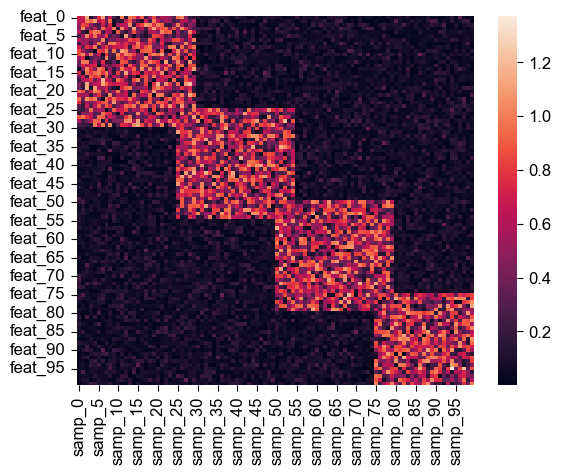

In [5]:
x = models.synthetic_data(overlap=0.2, k=4)
sns.heatmap(x)

## Rank selection
The number of ranks $k$ is unknown, however we can attempt to estimate it using bi-crossvalidation. This tries learning a held out part of the data using the other parts for a range of ranks a large number of times, and we look at measures of how well the held out part was estimated to identify a suitable rank. These are run from largest rank to smallest, so the estimate of time tends to start of conservative.

In [6]:
rank_sel_res = rank_selection(x=x, ranks=range(2, 11))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [02:03<00:00,  7.29it/s]


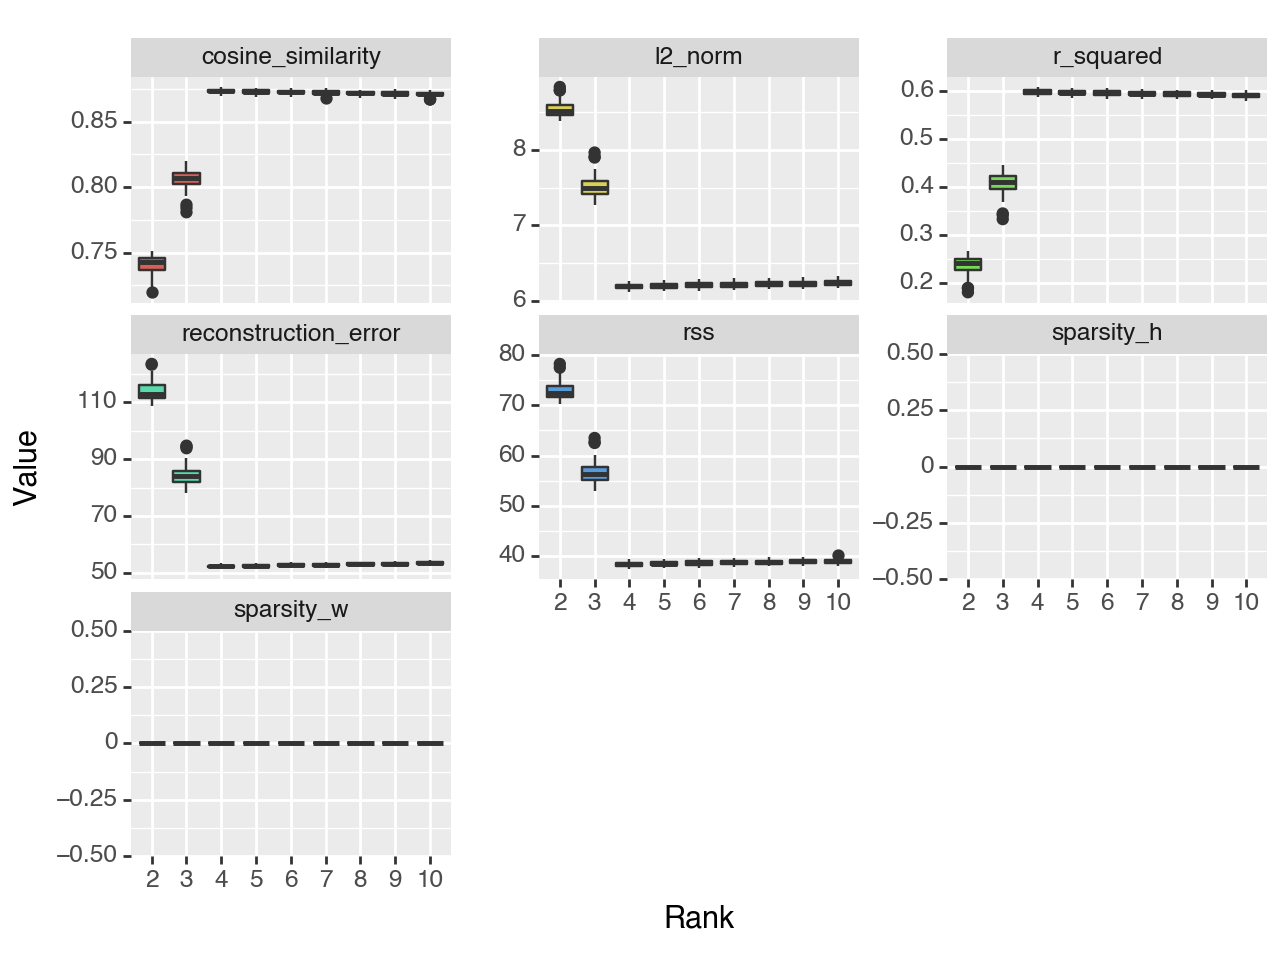

<Figure Size: (640 x 480)>

In [7]:
plot_rank_selection(rank_sel_res, jitter=False, n_col=3)

Cosine similarity increases rapidly at $k=4$, and declines after this, indicating this is a suitable rank. Real world examples will rarely be so clear, and often several ranks will appear suitable.

The different measures here are:
* *Cosine Similarity*: Higher is better. The angle between the true data and estimated data, considering each as a flattened 1d vector
* *L2 Norm*: Euclidean distance between true and estimated data. Lower is better.
* *R-squared*: Coefficient of determination between true and estimated data. Higher is better.
* *Reconstruction Error*: Measure of the error in the estimated data compared to true. Lower is better.
* *Residual Sum of Sqaures*: Lower is better
* *Sparsity H*: Sparsity of the H matrix
* *Sparsity W*: Sparsity of the W matrix

## Generating decompositions
For the ranks of interest, we can generate several decompositions to investigate. NMF solutions are non-unique and depend on the initialisation of the H and W matrices; some initialisations may give a better solution than others. One approach is to make many decompositions, and select those which optimise some criteria, such as reconstruction error.

Here we make 100 decompositions for each of ranks 3, 4, and 5, and keep only the top 5 for each rank. The result is a dictionary, with the key being the rank, and the value a list of Decompositions with the first being the best (lowest reconstruction error).

In [8]:
decomps = decompositions(x, ranks=[3, 4, 5], top_n=5, random_starts=100)
decomps

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 132.33it/s]


{3: [Decomposition[rank=3, beta_divergence=616],
  Decomposition[rank=3, beta_divergence=616],
  Decomposition[rank=3, beta_divergence=616],
  Decomposition[rank=3, beta_divergence=616],
  Decomposition[rank=3, beta_divergence=616]],
 4: [Decomposition[rank=4, beta_divergence=394],
  Decomposition[rank=4, beta_divergence=394],
  Decomposition[rank=4, beta_divergence=394],
  Decomposition[rank=4, beta_divergence=394],
  Decomposition[rank=4, beta_divergence=394]],
 5: [Decomposition[rank=5, beta_divergence=382],
  Decomposition[rank=5, beta_divergence=382],
  Decomposition[rank=5, beta_divergence=382],
  Decomposition[rank=5, beta_divergence=382],
  Decomposition[rank=5, beta_divergence=382]]}

We can inspect the decompositions using some inbuilt plotting functions

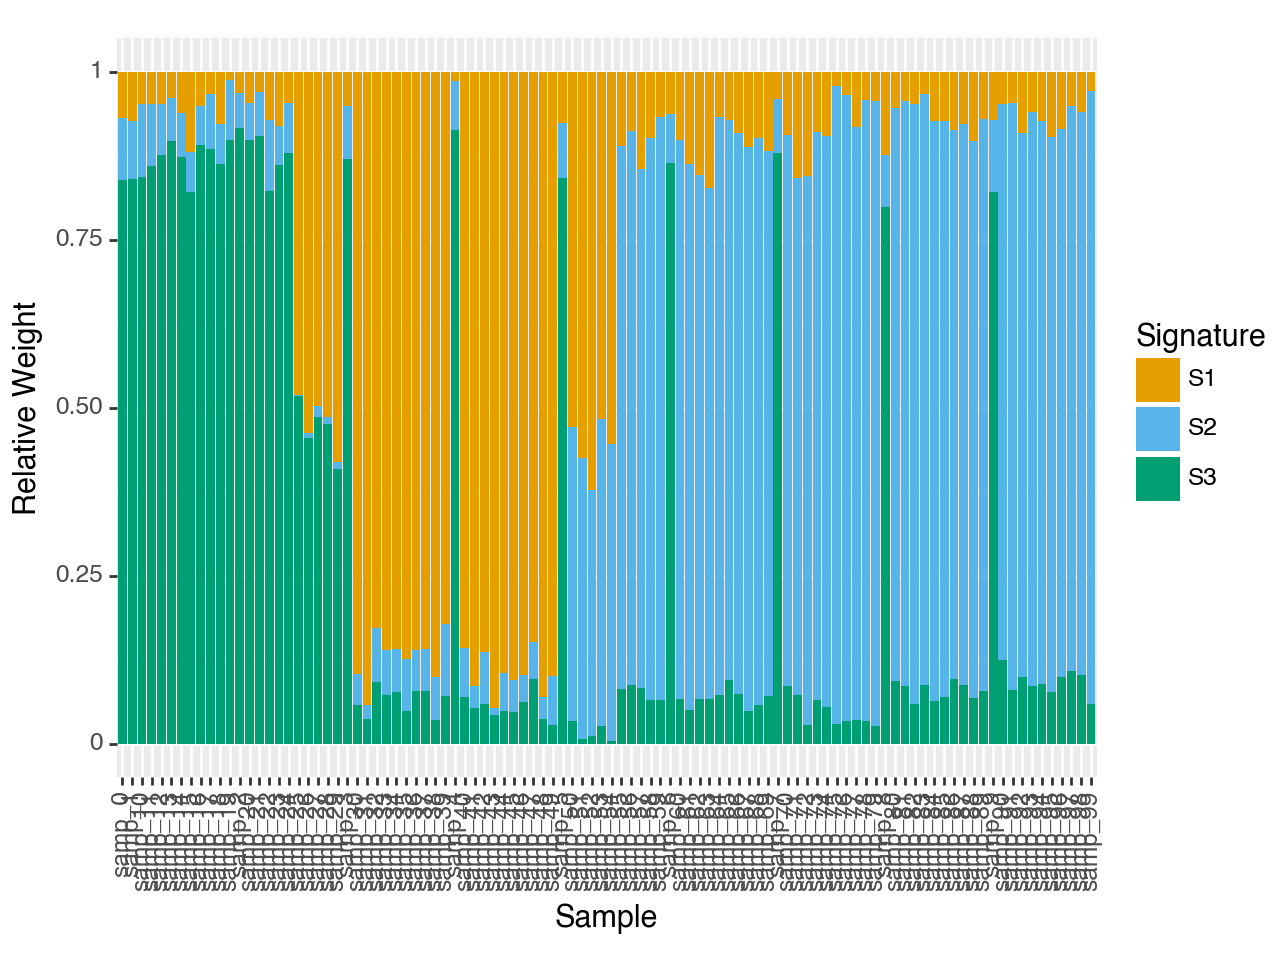

<Figure Size: (640 x 480)>

In [9]:
decomps[3][0].plot_relative_weight()

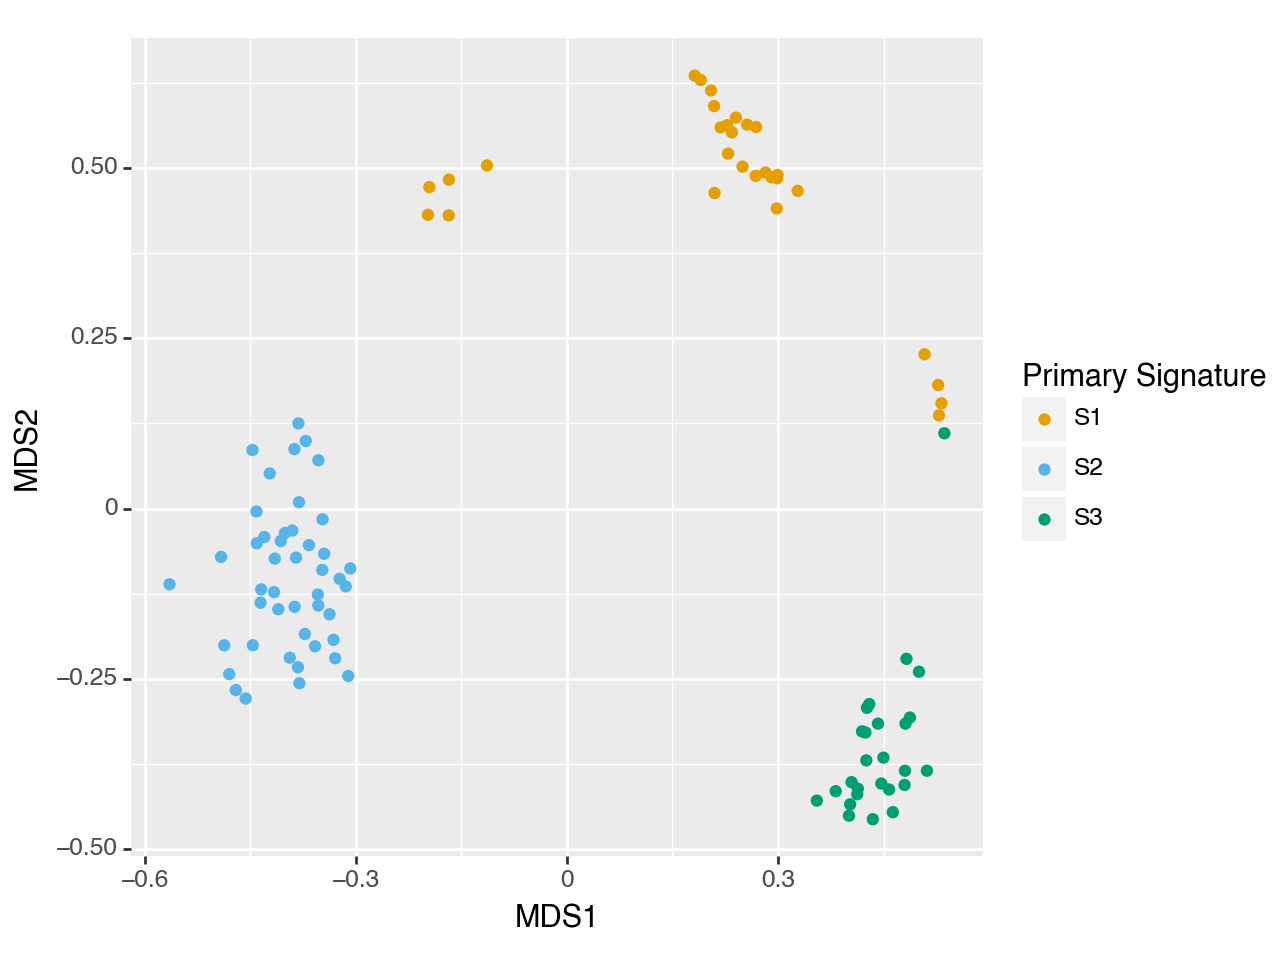

<Figure Size: (640 x 480)>

In [10]:
decomps[3][0].plot_pcoa()

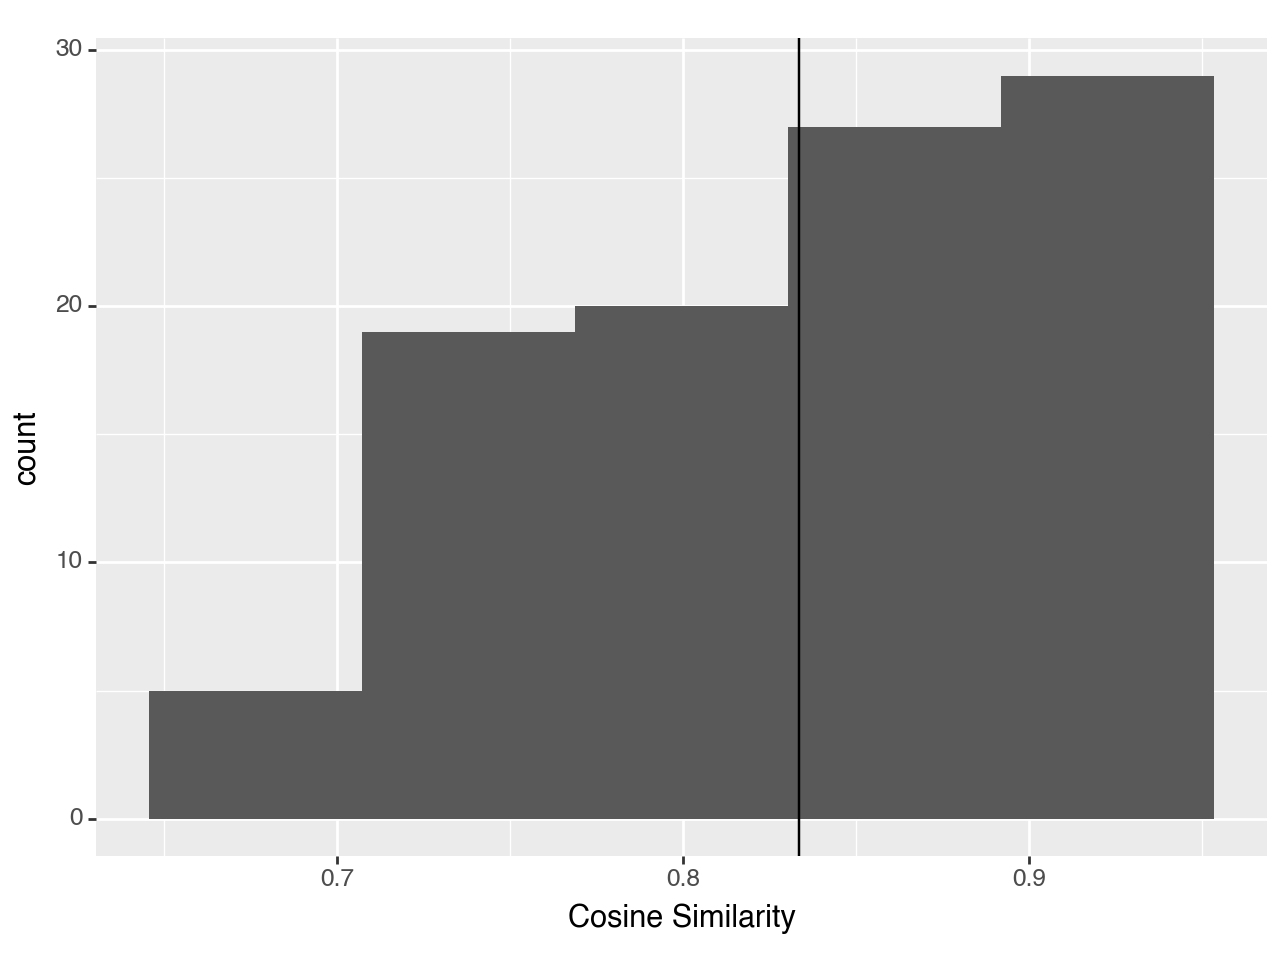

<Figure Size: (640 x 480)>

In [11]:
decomps[3][0].plot_modelfit()

## Saving and loading
Decompositions can be saved to disk for analysis in other environments, or saved and reloaded later.

In [20]:
Decomposition.save_decompositions(decomps, output_dir=pathlib.Path("test_save"), symlink=False)

In [21]:
! ls test_save/**/**

test_save/3/0:
h.tsv                         primary_signature.tsv
h_scaled.tsv                  properties.yaml
model_fit.tsv                 quality_series.tsv
monodominant_samples.tsv      representative_signatures.tsv
parameters.yaml               w.tsv
plot_modelfit.pdf             w_scaled.tsv
plot_pcoa.pdf                 x.tsv
plot_relative_weight.pdf

test_save/3/1:
h.tsv                         primary_signature.tsv
h_scaled.tsv                  properties.yaml
model_fit.tsv                 quality_series.tsv
monodominant_samples.tsv      representative_signatures.tsv
parameters.yaml               w.tsv
plot_modelfit.pdf             w_scaled.tsv
plot_pcoa.pdf                 x.tsv
plot_relative_weight.pdf

test_save/3/2:
h.tsv                         primary_signature.tsv
h_scaled.tsv                  properties.yaml
model_fit.tsv                 quality_series.tsv
monodominant_samples.tsv      representative_signatures.tsv
parameters.yaml               w.tsv
plot_modelfit.pd

In [24]:
loaded_decomps = Decomposition.load_decompositions(in_dir=pathlib.Path("test_save"))
loaded_decomps

{3: [Decomposition[rank=3, beta_divergence=616],
  Decomposition[rank=3, beta_divergence=616],
  Decomposition[rank=3, beta_divergence=616],
  Decomposition[rank=3, beta_divergence=616],
  Decomposition[rank=3, beta_divergence=616]],
 4: [Decomposition[rank=4, beta_divergence=394],
  Decomposition[rank=4, beta_divergence=394],
  Decomposition[rank=4, beta_divergence=394],
  Decomposition[rank=4, beta_divergence=394],
  Decomposition[rank=4, beta_divergence=394]],
 5: [Decomposition[rank=5, beta_divergence=382],
  Decomposition[rank=5, beta_divergence=382],
  Decomposition[rank=5, beta_divergence=382],
  Decomposition[rank=5, beta_divergence=382],
  Decomposition[rank=5, beta_divergence=382]]}

In [25]:
! rm -rf test_save